## Manage Colab Env/WD

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import json
import csv
from datetime import date
import traceback
import requests
import os
import pandas as pd

import torch
import torch.nn as nn

import glob
import librosa
import numpy as np
import collections
import contextlib
import sys
import wave

term = '2020'
docket = '18-540'
mod_path = "/content/model.model"
ap = '18-540_20201006-argument.delivery.mp3'
ap_wav = '18-540_argument.wav'

In [ ]:
!ls -ag

In [ ]:
!ls drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/ -ag

In [ ]:
!ls drive/My\ Drive/1006:\ Term\ Project/SCOTUS/ -ag

# Get desired audio file from web 
  - mostly to understand audio data scraping tools
  - test utilization in colab

In [ ]:
# Add court summaries file to WD
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/case_summaries.json /content/

In [ ]:
def get_http_json(url):
    print(f"Getting {url}")
    response = requests.get(url)
    parsed = response.json()
    return parsed

def get_case(term, docket):
    """Get the info of the case and fetch all
    transcripts that the info links to"""
    url = f"https://api.oyez.org/cases/{term}/{docket}"
    docket_data = get_http_json(url)

    if not (
        "oral_argument_audio" in docket_data and docket_data["oral_argument_audio"]
    ):
        # no oral arguments for this case yet
        # fail so we will try again later
        print(f"No oral arguments for docket {docket}")
        return (docket_data, [])

    oral_argument_audio = docket_data["oral_argument_audio"]
    transcripts = []
    for link in oral_argument_audio:
        t = get_http_json(link["href"])
        transcripts.append(t)

    return docket_data, transcripts

def getTranscript(transcripts):
    transcript_list = []
    speaker_list = []
    speaker_type_list = []
    time_list = []
    
    for t in transcripts:
        sections = t['transcript']['sections']
        for section in sections:
            turns = section['turns']
            for turn in turns:
                
                try:
                    speaker = turn['speaker']['name']
                except:
                    speaker = '<UNK>'
                speaker_list.append(speaker)   
                
                roles = turn['speaker']['roles']
                if isinstance(roles, list):
                    multiple_roles = []
                    for role in roles:
                        multiple_roles.append(role['type'])
                    speaker_type_list.append(multiple_roles)
                
                else:
                    speaker_type_list.append(['Other']) #Other is most likely Lawyer
                
                
                texts = turn['text_blocks']
                texts_out = []
                times_out = []
                for text in texts:
                    texts_out.append(text['text'])
                    times_out.append((text['start'],text['stop']))
                
                transcript_list.append(texts_out)
                time_list.append(times_out)

    return transcript_list, speaker_list, speaker_type_list, time_list

def getAudio(transcripts):
    num_files = len(transcripts)
    audio_list = []
    for t in transcripts:
        media_dicts = t['media_file']
        #just incase theres more than one, there shouldnt be but they re in a weird list
        for media_dict in media_dicts:
            audio_list.append(media_dict['href'])
    return [num_files,audio_list]

In [ ]:
# Get all the terms and dockets from case_summaries.json file
with open(os.getcwd() + '/case_summaries.json') as f:
    data = json.load(f)
    
case_summaries = pd.DataFrame(data)
case_summaries = case_summaries[['term', 'docket_number']]
# Let's start with 2020
case_summaries_2020 = case_summaries[case_summaries['term']=='2020']

In [ ]:
data = {}

for term, docket_number in case_summaries_2020.itertuples(index=False):
    docket_data, transcripts = get_case(term, docket_number)
    data[docket_number] = transcripts

Getting https://api.oyez.org/cases/2020/18-540
Getting https://api.oyez.org/case_media/oral_argument_audio/25077
Getting https://api.oyez.org/cases/2020/19-71
Getting https://api.oyez.org/case_media/oral_argument_audio/25058
Getting https://api.oyez.org/cases/2020/19-368
Getting https://api.oyez.org/case_media/oral_argument_audio/25061
Getting https://api.oyez.org/cases/2020/19-309
Getting https://api.oyez.org/case_media/oral_argument_audio/25055
Getting https://api.oyez.org/cases/2020/18-956
Getting https://api.oyez.org/case_media/oral_argument_audio/25092


In [ ]:
audio_path = getAudio(data[docket])[1][0].strip("'")

In [ ]:
#Add mp3 file to WD as determined thru getAudio function
!wget $audio_path

--2020-11-05 05:21:47--  https://s3.amazonaws.com/oyez.case-media.mp3/case_data/2020/18-540/18-540_20201006-argument.delivery.mp3
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17200673 (16M) [audio/mpeg]
Saving to: ‘18-540_20201006-argument.delivery.mp3’

18-540_20201006-arg 100%[===================>]  16.40M  20.9MB/s    in 0.8s    

2020-11-05 05:21:48 (20.9 MB/s) - ‘18-540_20201006-argument.delivery.mp3’ saved [17200673/17200673]



# Define and Load SpeechEmbedder()
  - Manually define SpeechEmbedder (could use import, demands files)
  - manually load model checkpoint `mod_path`
  - can resave, continue training, test
  - added .py and pip installs

#### copy necessary files for defining network
  - hparam.py
  - config/config.yaml
  - utils.py
  - model checkpoint `model.model`
  - could import all files (not necessary)

In [3]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/model.model /content/

In [4]:
!cp -r drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/fork/config .

In [5]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/fork/hparam.py .

In [6]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/utils.py .

In [7]:
#Add PyTorch_SV git repo files from google drive to colab drive mount (/content/)
#!cp -r drive/My\ Drive/1006\ Colab\ Notebooks/*.py .

In [8]:
!ls  -ag

total 47444
drwxr-xr-x 1 root     4096 Nov 21 01:26 .
drwxr-xr-x 1 root     4096 Nov 21 01:22 ..
drwx------ 2 root     4096 Nov 21 01:26 config
drwxr-xr-x 1 root     4096 Nov 13 17:34 .config
drwx------ 5 root     4096 Nov 21 01:26 drive
-rw------- 1 root     1649 Nov 21 01:26 hparam.py
-rw------- 1 root 48543272 Nov 21 01:26 model.model
drwxr-xr-x 1 root     4096 Nov 13 17:33 sample_data
-rw------- 1 root     6890 Nov 21 01:26 utils.py


#### Load SpeechEmbedder
  - embedder_net w/ final checkpoint params

In [21]:
import hparam
import importlib as reimport
reimport.reload(hparam)
from hparam import hparam_SCOTUS as hp
from utils import get_centroids, get_cossim, calc_loss


In [10]:
class SpeechEmbedder(nn.Module):
    
    def __init__(self):
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(hp.data.nmels, hp.model.hidden, num_layers=hp.model.num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hp.model.hidden, hp.model.proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

In [11]:
embedder_net = SpeechEmbedder()
chk = torch.load(mod_path)
embedder_net.load_state_dict(chk)
embedder_net.to(hp.device)

SpeechEmbedder(
  (LSTM_stack): LSTM(40, 768, num_layers=3, batch_first=True)
  (projection): Linear(in_features=768, out_features=256, bias=True)
)

In [12]:
#Add TIMIT test data to colab drive mount (if you want to evaluate model)
#!cp -r drive/My\ Drive/1006\ Colab\ Notebooks/test_tisv .

In [13]:
# Resave model as state_dict
#torch.save(model.state_dict(), "drive/My Drive/Colab Notebooks/model_statedict.pt")

#### colab package installs
  - install/import webrtcvad (VAD_chunk)
  - install/import pydub (mp3 $\rightarrow$ wav)

In [14]:
# Install webrtcvad in google colab (must be ran every time)
!pip install webrtcvad

     |████████████████████████████████| 71kB 6.3MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=71314 sha256=3086bf654579340c47c919b1cdf128311f0bc61e1f58ae174dd85195a8e904f5
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad


In [15]:
!pip install pydub

In [16]:
import pydub
import webrtcvad

#### .py functions

In [17]:
def concat_segs(times, segs):
    #Concatenate continuous voiced segments
    concat_seg = []
    seg_concat = segs[0]
    for i in range(0, len(times)-1):
        if times[i][1] == times[i+1][0]:
            seg_concat = np.concatenate((seg_concat, segs[i+1]))
        else:
            concat_seg.append(seg_concat)
            seg_concat = segs[i+1]
    else:
        concat_seg.append(seg_concat)
    return concat_seg

def get_STFTs(segs):
    #Get 240ms STFT windows with 50% overlap
    sr = hp.data.sr
    STFT_frames = []
    for seg in segs:
        S = librosa.core.stft(y=seg, n_fft=hp.data.nfft,
                              win_length=int(hp.data.window * sr), hop_length=int(hp.data.hop * sr))
        S = np.abs(S)**2
        mel_basis = librosa.filters.mel(sr, n_fft=hp.data.nfft, n_mels=hp.data.nmels)
        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
        for j in range(0, S.shape[1], int(.12/hp.data.hop)):
            if j + 24 < S.shape[1]:
                STFT_frames.append(S[:,j:j+24])
            else:
                break
    return STFT_frames

def align_embeddings(embeddings):
    partitions = []
    start = 0
    end = 0
    j = 1
    for i, embedding in enumerate(embeddings):
        if (i*.12)+.24 < j*.401:
            end = end + 1
        else:
            partitions.append((start,end))
            start = end
            end = end + 1
            j += 1
    else:
        partitions.append((start,end))
    avg_embeddings = np.zeros((len(partitions),256))
    for i, partition in enumerate(partitions):
        avg_embeddings[i] = np.average(embeddings[partition[0]:partition[1]],axis=0) 
    return avg_embeddings


def read_wave(path, sr):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    Assumes sample width == 2
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
    data, _ = librosa.load(path, sr)
    assert len(data.shape) == 1
    assert sr in (8000, 16000, 32000, 48000)
    return data, pcm_data
    
class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start = ring_buffer[0][0].timestamp
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield (start, frame.timestamp + frame.duration)
                ring_buffer.clear()
                voiced_frames = []
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield (start, frame.timestamp + frame.duration)


def VAD_chunk(aggressiveness, path):
    audio, byte_audio = read_wave(path, hp.data.sr)
    vad = webrtcvad.Vad(int(aggressiveness))
    frames = frame_generator(20, byte_audio, hp.data.sr)
    frames = list(frames)
    times = vad_collector(hp.data.sr, 20, 200, vad, frames)
    speech_times = []
    speech_segs = []
    for i, time in enumerate(times):
        start = np.round(time[0],decimals=2)
        end = np.round(time[1],decimals=2)
        j = start
        while j + .4 < end:
            end_j = np.round(j+.4,decimals=2)
            speech_times.append((j, end_j))
            speech_segs.append(audio[int(j*hp.data.sr):int(end_j*hp.data.sr)])
            j = end_j
        else:
            speech_times.append((j, end))
            speech_segs.append(audio[int(j*hp.data.sr):int(end*hp.data.sr)])
    return speech_times, speech_segs

# d-Vector engineering
  - process audio file
  - compile `dvector_create.py` inner training loop for single (full) argument
  - output embedding of argument (subsample of argument)

### Construct Single d-vector manually
  - independently define `dvector_create.py, VAD_segments.py` functions
  - mp3 (could be flacc) audio file  $\rightarrow$ properly sampled .wav 
  - .wav $\rightarrow$ STFT representation of full audio file
  - utilize `SpeechEmbedder()`

#### audio processing


In [ ]:
#mp3 to wav with predefined frame_rate/sample_rate 

#!rm 18-540_argument.wav
sound = pydub.AudioSegment.from_mp3(ap)
sound = sound.set_frame_rate(hp.data.sr)
sound.export(ap_wav, format="wav")

<_io.BufferedRandom name='18-540_argument.wav'>

In [ ]:
ap_wav = 

In [ ]:
train_sequence = []
train_cluster_id = []
label = 0
count = 0
train_saved = False

In [ ]:
'''
2 -> webrtcvad.Vad(2)
webrtcvad github: aggressiveness mode, 
which is an integer between 0 and 3. 
0 is the least aggressive about 
filtering out non-speech, 
3 is the most aggressive.
'''

times, segs = VAD_chunk(2, ap_wav)

In [ ]:
# probably where we will need to 
# keep track of our alignment 
# with speaker labels
concat_seg = concat_segs(times, segs)

In [ ]:
print(type(times))
print(type(times[0]))
print(type(segs))
print(type(segs[0]))
print("times[0]:", times[0])
print("times[1]:", times[1])
print("times[-2]:", times[-2])
print("times[-1]:", times[-1])
print("segs[0] shape:", np.shape(segs[0])[0])

<class 'list'>
<class 'tuple'>
<class 'list'>
<class 'numpy.ndarray'>
times[0]: (0.1, 0.5)
times[1]: (0.5, 0.9)
times[-2]: (4292.4, 4292.8)
times[-1]: (4292.8, 4292.82)
segs[0] shape: 6400


In [ ]:
len(concat_seg)

573

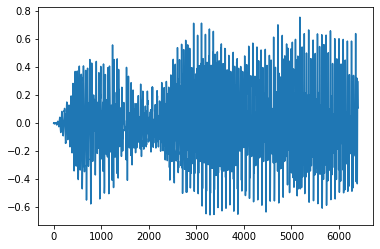

In [ ]:
# Visualization of sound wave estimation 
# for time slice where voice activity is detected
import matplotlib.pyplot as plt
plt.plot(range(np.shape(segs[0])[0]), segs[0])
plt.show()

In [ ]:
'''
Short Time Fourier Transform
from function comments: 240ms STFT windows with 50% overlap
outputs 40 X 24 -> 
  - 40=number of mel energies (hparam)
  - 24 = ?...
'''
STFT_frames = get_STFTs(concat_seg)

In [ ]:
print("# frames (depends on file size):", len(STFT_frames))
print("Predefined output shape:", np.shape(STFT_frames[0]))

# frames (depends on file size): 33349
Predefined output shape: (40, 24)


In [ ]:
# reshape & convert to tensor
STFT_frames = np.stack(STFT_frames, axis=2)
STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
print("STFT size:", STFT_frames.size())

STFT size: torch.Size([33349, 24, 40])


In [ ]:
# 33349 to large for available RAM in Colab (total of 10GB i think!)
# 500 slice limit sample for testing
# send to device here to save RAM
STFT_sample = STFT_frames[0:500, :, :].to(hp.device)

#### Embedding

In [ ]:
# Generate embedding
# model will be on eval for court arguments
embedder_net.eval()
embedder_net.to(hp.device)
embeddings = embedder_net(STFT_sample)

In [ ]:
embeddings.size()

torch.Size([500, 256])

In [ ]:
def align_embeddings(embeddings):
    partitions = []
    start = 0
    end = 0
    j = 1
    for i, embedding in enumerate(embeddings):
        if (i*.12)+.24 < j*.401:
            end = end + 1
        else:
            partitions.append((start,end))
            start = end
            end = end + 1
            j += 1
    else:
        partitions.append((start,end))
    avg_embeddings = np.zeros((len(partitions),256))
    for i, partition in enumerate(partitions):
        avg_embeddings[i] = np.average(embeddings[partition[0]:partition[1]],axis=0) 
    return avg_embeddings

In [ ]:
aligned_embeddings = align_embeddings(embeddings.detach().cpu().numpy())

In [ ]:
np.shape(aligned_embeddings)

(150, 256)

# dvector_create Loop Engineering
  - basically had to do a new training loop to handle
    - parsing sequences by cases
    - handling reoccuring judge labels
    - processing short wavs (it spots SOME low value .wav, added more checks)
    - etc.

In [23]:
#set hp.unprocessed_data in config to use dvector_create.py
#path = 'drive/My Drive/1006: Term Project/SCOTUS/*/*'

#dataset path
case_path = glob.glob(os.path.dirname(hp.unprocessed_data))

min_va = 2 # minimum voice activity length
label = 20 # unknown speaker label counter (leave room for 20 judges)

cnt = 0 # counter for judge_dict
judge_dict = dict()

verbose = hp.data.verbose
embedder_net.eval()


SpeechEmbedder(
  (LSTM_stack): LSTM(40, 768, num_layers=3, batch_first=True)
  (projection): Linear(in_features=768, out_features=256, bias=True)
)

In [ ]:
for i, folder in enumerate(case_path):
  case = folder.split('/')[-1]
  if verbose:
    print("Processing case:", case)
  rm_pthlst = []
  case_file_lst = []
  case_sequence = []
  case_cluster_id = []
  spkrtracker=0
  
  for spkr_name in os.listdir(folder):
    casecount = 0
    if verbose:
      print("Processing spkr:", spkr_name)

    #Build Judge Dictionary & Handle Other
    if spkr_name[-14:]=='scotus_justice':
      if spkr_name[:-15] in judge_dict:
        use_label = judge_dict[spkr_name[:-15]]
      else:
        judge_dict[spkr_name[:-15]] = cnt
        use_label = judge_dict[spkr_name[:-15]]
        cnt+=1
    else:
      use_label = label 
      label+=1

    spkr_file_lst = []
    spkr_sequence = []
    spkr_cluster_lst = []

    for file in os.listdir(folder+'/'+spkr_name):
      if file[-4:] == '.wav':
        times, segs = VAD_chunk(2, folder+'/'+spkr_name+'/'+file)

        # Bad .wav detection
        if segs == []:
          #print('No voice activity detected')
          rm_pthlst.append(folder+'/'+file)
          continue

        concat_seg = concat_segs(times, segs)
        if len(concat_seg)<min_va:
          #print('Below Minimum voice activity detected')
          rm_pthlst.append(folder+'/'+file)
          continue
           
        STFT_frames = get_STFTs(concat_seg)
        STFT_frames = np.stack(STFT_frames, axis=2)
        STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
        STFT_frames = STFT_frames.to(hp.device)
        embeddings = embedder_net(STFT_frames)
        aligned_embeddings = align_embeddings(embeddings.detach().cpu().numpy())
        
        spkr_sequence.append(aligned_embeddings)
        spkr_cluster_id = []
        for embedding in aligned_embeddings:
          spkr_cluster_id.append(str(use_label)) #use_label handling judge id

        #Track full names of processed wav files
        pth = file.split(".")[0]+'.txt'
        pth = case+'/'+spkr_name+'/'+pth
        f = open(hp.data.main_path+pth, 'r')
        f = f.read().split(" ")
        spkr_file_lst.append((f[0], f[1], np.shape(aligned_embeddings)[0], casecount, spkrtracker))
        spkr_cluster_lst.append(spkr_cluster_id)
        casecount = casecount + 1

    if verbose:
      print('Processed', casecount, 'files for case', case, 'for spkr', spkr_name)
    case_file_lst.append(spkr_file_lst)
    case_sequence.append(spkr_sequence)
    case_cluster_id.append(spkr_cluster_lst)
    spkrtracker+=1

  if verbose:
    print('Handled', spkrtracker, 'speakers for case', case)
    print('saving case sequence', case)

  fold = hp.data.save_path+case+'/'
  if not os.path.exists(fold):
    os.makedirs(fold)
  temp_sequence = np.asarray(case_sequence, dtype='object')
  temp_cluster_id = np.asarray(case_cluster_id, dtype='object')
  np.save(fold+case+'_embarr',temp_sequence)
  np.save(fold+case+'_labelarr',temp_cluster_id)
  temp_sequence = []
  temp_cluster_id = []

  info_lst=[item for sublist in case_file_lst for item in sublist]
  with open(fold+case+'_info.csv', 'w+') as file:     
    write = csv.writer(file) 
    write.writerows(info_lst)

  with open(fold+case+'_2remove.csv', 'w') as rm:
    wr = csv.writer(rm, delimiter=",")
    wr.writerow(rm_pthlst)


In [40]:
case_path = glob.glob(os.path.dirname(hp.data.save_path+'*/*'))
verbose = hp.data.verbose
  
# Reconstructs alignments and labels in order
for i, folder in enumerate(case_path):
    case = folder.split('/')[-1]
    if verbose:
      print("Aligning case ", case[:-7])
      
    with open(folder+'/'+case+'_info.csv') as f:
        reader = csv.reader(f)
        path = list(reader)
    srtlst = sorted(path, key=lambda x: x[0])
    temp_sequence = np.load(folder+'/'+case+'_embarr.npy', allow_pickle=True)
    temp_cluster_id = np.load(folder+'/'+case+'_labelarr.npy', allow_pickle=True)
    
    sizetemp=0
    temp_lst = []
    temp_id_lst = []
    for t0,t1,s,i,j in srtlst:
      sizetemp+=int(s)
      temp_lst.append(temp_sequence[int(j)][int(i)])
      temp_id_lst.append(temp_cluster_id[int(j)][int(i)])
      
    case_emb = np.concatenate(temp_lst, axis=0)
    case_label = np.concatenate(temp_id_lst, axis=0)
      
    if verbose:
        print("Expected Sequence Shape:", sizetemp, " X ", hp.model.proj)
        print("Expected ID Shape:", sizetemp, " X ", '')
        print("Sequence Shape:", np.shape(case_emb))
        print("ID Shape:", np.shape(case_label))
        
    np.save(folder+'/'+case[:-7]+'_sequence.npy', case_emb)
    np.save(folder+'/'+case[:-7]+'_cluster_id.npy', case_label)


Aligning case  17-1268
Expected Sequence Shape: 7634  X  256
Expected ID Shape: 7634  X  
Sequence Shape: (7634, 256)
ID Shape: (7634,)
Aligning case  18-1150
Expected Sequence Shape: 7391  X  256
Expected ID Shape: 7391  X  
Sequence Shape: (7391, 256)
ID Shape: (7391,)
Aligning case  18-280
Expected Sequence Shape: 6606  X  256
Expected ID Shape: 6606  X  
Sequence Shape: (6606, 256)
ID Shape: (6606,)
Aligning case  18-916
Expected Sequence Shape: 8462  X  256
Expected ID Shape: 8462  X  
Sequence Shape: (8462, 256)
ID Shape: (8462,)
Aligning case  19-431
Expected Sequence Shape: 12762  X  256
Expected ID Shape: 12762  X  
Sequence Shape: (12762, 256)
ID Shape: (12762,)


#UISRNN

# PyTorch SV dvector_create guts / Scrap
  - dont run, just for reference


In [ ]:
times, segs = VAD_chunk(2, ap_wav)
if segs == []:
    print('No voice activity detected')
else:
  print("proceeding") 
concat_seg = concat_segs(times, segs)
STFT_frames = get_STFTs(concat_seg)
STFT_frames = np.stack(STFT_frames, axis=2)
STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
print("up to embedder")
embeddings = embedder_net(STFT_frames)
aligned_embeddings = align_embeddings(embeddings.detach().numpy())
train_sequence.append(aligned_embeddings)
for embedding in aligned_embeddings:
    train_cluster_id.append(str(label))
if count == 0:
    print('Processed {0}/{1} files'.format(count, len(audio_path)))

In [ ]:
path = ap_wav
with contextlib.closing(wave.open(path, 'rb')) as wf:
  print("test:", wf.getframerate())
  num_channels = wf.getnchannels()
  assert num_channels == 1
  sample_width = wf.getsampwidth()
  assert sample_width == 2
  sample_rate = wf.getframerate()
  assert sample_rate in (8000, 16000, 32000, 48000)
  pcm_data = wf.readframes(wf.getnframes())
data, _ = librosa.load(path, sr)
assert len(data.shape) == 1
assert sr in (8000, 16000, 32000, 48000)

test: 16000


In [ ]:
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)

In [ ]:
!python dvector_create.py

Traceback (most recent call last):
  File "dvector_create.py", line 119, in <module>
    train_sequence = np.concatenate(train_sequence,axis=0)
  File "<__array_function__ internals>", line 6, in concatenate
ValueError: need at least one array to concatenate


##### dvec loop first draft

In [ ]:
#set hp.unprocessed_data in config to use dvector_create.py
audio_path = glob.glob(os.path.dirname('drive/My Drive/1006: Term Project/SCOTUS/*/*/*.wav'))

In [ ]:
# Shorten for immediate testing
audio_path = audio_path[:21]

In [ ]:
total_case_num = len(case_path)
train_case_num= len(case_path)-2         # split total data 90% train and 10% test

embedder_net.eval()

train_saved = False
train_sequence = []
train_cluster_id = []
trn_pthlst = [] # list of processed wav files (training)
tst_pthlst = [] # list of processed wav files (testing)
rm_pthlst = [] #list of wav files too short to process 

label = 20 # unknown speaker label counter (leave room for 20 judges)
cnt = 0 # judge counter
min_va = 2 #minimum voice activity length

judge_dict = dict()


for i, folder in enumerate(audio_path):
  count = 0
  ts_file_lst = []
  print(folder)

  #Build Judge Dictionary & Handle Other
  spkr_name = folder.split('/')[-1]
  if spkr_name[-14:]=='scotus_justice':
    if spkr_name[:-15] in judge_dict:
      use_label = judge_dict[spkr_name[:-15]]
    else:
      judge_dict[spkr_name[:-15]] = cnt
      use_label = judge_dict[spkr_name[:-15]]
      cnt+=1
  else:
    use_label = label 
    label+=1

  for file in os.listdir(folder):
    if file[-4:] == '.wav':
      times, segs = VAD_chunk(2, folder+'/'+file)

      # Bad .wav detection
      if segs == []:
        #print('No voice activity detected')
        rm_pthlst.append(folder+'/'+file)
        continue

      concat_seg = concat_segs(times, segs)
      if len(concat_seg)<min_va:
        #print('Below Minimum voice activity detected')
        rm_pthlst.append(folder+'/'+file)
        continue
      
      
      STFT_frames = get_STFTs(concat_seg)
      STFT_frames = np.stack(STFT_frames, axis=2)
      STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
      embeddings = embedder_net(STFT_frames)
      aligned_embeddings = align_embeddings(embeddings.detach().numpy())
      train_sequence.append(aligned_embeddings)
      for embedding in aligned_embeddings:
        train_cluster_id.append(str(use_label)) #use_label handling judge id

      #Track full names of processed wav files
      f = file.split(".")[0]+'.txt'
      ts_file_lst.append([folder+'/'+f, np.shape(aligned_embeddings)[0]])
      count = count + 1 

  if not train_saved:
    trn_pthlst.append(ts_file_lst)
  else:
    tst_pthlst.append(ts_file_lst)

  print('Processed {0}/{1} files'.format(count, len(os.listdir(audio_path[i]))))
  if i % 5 == 0:
    print('Processed {0}/{1} folders'.format(i, len(audio_path)))
    
  if not train_saved and i > train_speaker_num:
      train_sequence = np.concatenate(train_sequence,axis=0)
      train_cluster_id = np.asarray(train_cluster_id)
      np.save('train_sequence',train_sequence)
      np.save('train_cluster_id',train_cluster_id)
      train_saved = True
      train_sequence = []
      train_cluster_id = []
        
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)
np.save('test_sequence',train_sequence)
np.save('test_cluster_id',train_cluster_id)

drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Christopher_M_Curran_Other
Processed 35/166 files
Processed 0/21 folders
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/John_G_Roberts_Jr_scotus_justice
Processed 4/12 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Elena_Kagan_scotus_justice
Processed 7/28 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Matthew_D_McGill_Other
Processed 16/40 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Ruth_Bader_Ginsburg_scotus_justice
Processed 5/18 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Erica_L_Ross_Other
Processed 6/30 files
Processed 5/21 folders
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Neil_Gorsuch_scotus_justice
Processed 5/34 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Samuel_A_Alito_Jr_scotus_justice
Processed 11/34 files
drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Sonia_Sotomayor_scotus_justice
Processed 7/30 files
d

In [ ]:
judge_dict

{'Brett_M_Kavanaugh': 7,
 'Elena_Kagan': 1,
 'John_G_Roberts_Jr': 0,
 'Neil_Gorsuch': 3,
 'Ruth_Bader_Ginsburg': 2,
 'Samuel_A_Alito_Jr': 4,
 'Sonia_Sotomayor': 5,
 'Stephen_G_Breyer': 6}

In [ ]:
!ls

config	   model.model	test_cluster_id.npy   train_sequence.npy
drive	   __pycache__	test_sequence.npy     utils.py
hparam.py  sample_data	train_cluster_id.npy


In [ ]:
!mv *.npy drive/My\ Drive/1006:\ Term\ Project/SCOTUS_numpy/

In [ ]:
!ls drive/My\ Drive/1006:\ Term\ Project/SCOTUS_numpy/

test_cluster_id.npy  train_cluster_id.npy
test_sequence.npy    train_sequence.npy


In [ ]:
train_cluster_id = np.load('drive/My Drive/1006: Term Project/SCOTUS_numpy/train_cluster_id.npy')
test_cluster_id = np.load('drive/My Drive/1006: Term Project/SCOTUS_numpy/test_cluster_id.npy')
train_sequence = np.load('drive/My Drive/1006: Term Project/SCOTUS_numpy/train_sequence.npy')
test_sequence = np.load('drive/My Drive/1006: Term Project/SCOTUS_numpy/test_sequence.npy')

In [ ]:
np.shape(train_sequence)

(14418, 256)

In [ ]:
len(train_cluster_id)

14418

In [ ]:
# [case][spkr][path or length]
len(trn_pthlst[0])

35

In [ ]:
trn_pthlst[1]

[['drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/John_G_Roberts_Jr_scotus_justice/John_G_Roberts_Jr_scotus_justice_0.txt',
  21],
 ['drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/John_G_Roberts_Jr_scotus_justice/John_G_Roberts_Jr_scotus_justice_54.txt',
  5],
 ['drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/John_G_Roberts_Jr_scotus_justice/John_G_Roberts_Jr_scotus_justice_225.txt',
  9],
 ['drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/John_G_Roberts_Jr_scotus_justice/John_G_Roberts_Jr_scotus_justice_239.txt',
  5]]

In [ ]:
len_

#### scrap from loop cleanup

In [ ]:
temp_sequence = np.load('drive/My Drive/1006: Term Project/SCOTUS_Processed/train/17-1268_SCOTUS_seq.npy',allow_pickle=True)
temp_cluster_id = np.load('drive/My Drive/1006: Term Project/SCOTUS_Processed/train/17-1268_SCOTUS_id.npy', allow_pickle=True)

In [ ]:
print(sum([len(temp_sequence[i]) for i in range(len(temp_sequence))]))

112


In [ ]:
'''
Build dictionary with 
txt file information
'''

dir = 'drive/My Drive/1006: Term Project/SCOTUS/'
savedir = 'drive/My Drive/1006: Term Project/SCOTUS_Processed/'

aligndict = dict()
sz_lst = []
siz = 0
for case in trn_pthlst:
  aligndict[case] = dict()
  time_lst = []
  i = 0
  for tup, spkr in trn_pthlst[case]:
    j = 0
    print('t', tup)
    for pth, sz in tup:
      siz+=sz
      f = open(dir+pth, 'r')
      f = f.read().split(" ")
      time_lst.append((f[0],f[1], sz, i, j))
      j+=1
    i+=1
  sz_lst.append(siz)
  aligndict[case] = time_lst

t [('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_55.txt', 100), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_61.txt', 72), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_59.txt', 229), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_63.txt', 56), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_57.txt', 185), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_83.txt', 120), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_91.txt', 5), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_77.txt', 98), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_85.txt', 120), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_89.txt', 45), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_100.txt', 28), ('17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M

In [ ]:
len(time_lst)

112

In [ ]:
pth

'17-1268_SCOTUS/Stephen_G_Breyer_scotus_justice/Stephen_G_Breyer_scotus_justice_227.txt'

In [ ]:
srtlst = Sort_Tuple(aligndict['17-1268_SCOTUS'])

In [ ]:


case1 = np.concatenate(temp_lst, axis=0)
print("Expected Shape:", sz_lst[0], " X ", 256)
print(np.shape(case1))

Expected Shape: 7634  X  256
(7634, 256)


In [ ]:
case1_id = np.concatenate(temp_cluster_id, axis=0)
np.shape(case1_id)

(7634,)

In [ ]:
# Save Case representation in case directory
np.save(savedir+'train/'+'17-1268_SCOTUS/17-1268_emb.npy', case1)
np.save(savedir+'train/'+'17-1268_SCOTUS/17-1268_id.npy', case1_id)